## 1) Feature Detection

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from scipy.signal import convolve2d as conv2d
from scipy.signal import convolve as conv2d
import scipy.ndimage


def image_gradient(I):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    
    m, n = I.shape[:2]
    
    # Convert input to grayscale
    if m == 256 and n == 256:
        I_grayscale = I
    
    else:
        I_grayscale = 0.21263903 * I[:,:,0] + 0.71516871 * I[:,:,1] + 0.072192319 * I[:,:,2] 
    
    # Initialize Ix and Iy
    Ix = np.zeros((m, n))
    Iy = np.zeros((m, n))
    
    # Initialize weight w
    w = np.array([-1/12, 8/12, 0, -8/12, 1/12])
    
    # Derivative in 1D using 5-point central difference and convolution
    for i in range(2, m-2):
        for j in range(2, n-2):
            Ix[i,j] = conv2d(I_grayscale[i, j-2:j+3], w, mode = 'valid', method = 'direct')
            Iy[i,j] = conv2d(I_grayscale[i-2:i+3, j], w.T, mode = 'valid', method = 'direct')

    
    return Ix, Iy
  

def minor_eigenvalue_image(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0.
    
    pad = int((w-1)/2)
    
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    # Shi-Tomasi corner detector algorithm
    for i in range(pad, m - pad):
        for j in range(pad, n - pad):
            M = np.array([ [np.sum(Ixx[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1])], [np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(Iyy[i-pad:i+pad+1, j-pad:j+pad+1])] ])
            
            J0[i,j] = ( np.trace(M) - np.sqrt( max( 0, (np.trace(M)**2 - 4*np.linalg.det(M)) ) ) )/2



    return J0
  
def nms(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    J2 = J.copy()
    
    m, n = J2.shape[:2]
    
    R_max = scipy.ndimage.maximum_filter(J, size = w_nms)
    
    for i in range(m):
        for j in range(n):
            if J2[i,j] < R_max[i,j]:
                J2[i,j] = 0
                
    return J2
  
  
def forstner_corner_detector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))
    
    # Calculation of minor eigenvalue image J0
    J0 = minor_eigenvalue_image(Ix, Iy, w)
    
    # Calculation of thresholded version J1
    for i in range(m):
        for j in range(n):
            if J0[i,j] > t:
                J1[i,j] = J0[i,j]
                
    #Run non-maxima suppression on your thresholded minor eigenvalue image
    J2 = nms(J1, w_nms)
    
    #Detect corners
    
    pad = int((w-1)/2)
    C   = np.count_nonzero(J2)
    pts = np.zeros((2, C))
    _c  = 0
    
    x   = np.array([[i for i in range(n)] for j in range(m)])
    y   = np.array([[j for i in range(n)] for j in range(m)])
    
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    xIxx = x * Ixx
    xIxy = x * Ixy
    yIxy = y * Ixy
    yIyy = y * Iyy
    
    # Calculate coordinates of corner point in window using Forstner detection algorithm
    
    for i in range(m):
        for j in range(n):
            if J2[i,j] != 0:
                A = np.array([ [np.sum(Ixx[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1])], [np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(Iyy[i-pad:i+pad+1, j-pad:j+pad+1])] ])
                B = np.array([ np.sum(xIxx[i-pad:i+pad+1, j-pad:j+pad+1] + yIxy[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(xIxy[i-pad:i+pad+1, j-pad:j+pad+1] + yIyy[i-pad:i+pad+1, j-pad:j+pad+1]) ])
                pts[:, _c] = (np.linalg.inv(A) @ B)
                _c += 1
    
    return C, pts, J0, J1, J2


# feature detection
def run_feature_detection(I, w, t, w_nms):
    Ix, Iy = image_gradient(I)
    C, pts, J0, J1, J2 = forstner_corner_detector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

In [2]:
# ImageGradient() unit test
def check_values(I, target):
    eps = 1e-8  # Floating point error threshold
    I = I[2:-2, 2:-2]  # Ignore border values
    valid = np.all((I < target + eps) & (I > target - eps))
    print(f'Image is all equal to {target} +/- {eps}: {valid}')
    
def gray_to_RGB(I):
    h, w = I.shape
    I = np.expand_dims(I, axis=-1)
    return np.broadcast_to(I, (h, w, 3))

rampx = np.array(Image.open('rampx.png'), dtype='float')
rampy = np.array(Image.open('rampy.png'), dtype='float')

# If you are using grayscale images in ImageGradient(), comment out these lines 
# rampx = gray_to_RGB(rampx)
# rampy = gray_to_RGB(rampy)

# rampx_Ix should be all ones, rampx_Iy should be all zeros (to floating point error)
rampx_Ix, rampx_Iy = image_gradient(rampx) 
check_values(rampx_Ix, 1)
check_values(rampx_Iy, 0)

# rampy_Ix should be all zeros, rampx_Iy should be all ones (to floating point error)
rampy_Ix, rampy_Iy = image_gradient(rampy)
check_values(rampy_Ix, 0)
check_values(rampy_Iy, 1)

Image is all equal to 1 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 1 +/- 1e-08: True


took 71.352498 secs


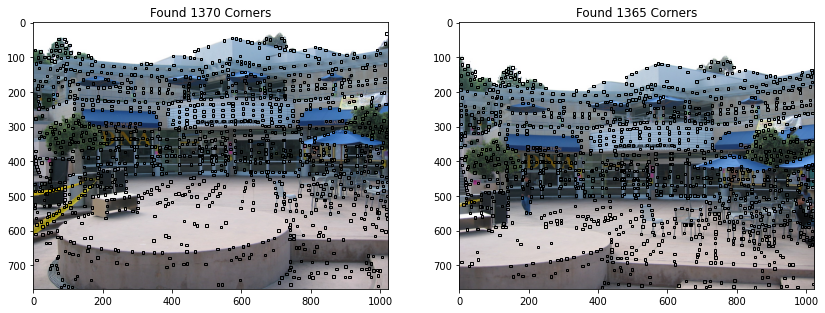

In [3]:
import time

# input images
I1 = np.array(Image.open('IMG_5030.jpg'), dtype='float')/255.
I2 = np.array(Image.open('IMG_5031.jpg'), dtype='float')/255.

# parameters to tune
w = 7
t = 0.0075
w_nms = 11

tic = time.time()

# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = run_feature_detection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = run_feature_detection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1,2,1)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('Found %d Corners'%C1)

ax = plt.subplot(1,2,2)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('Found %d Corners'%C2)

plt.show()

#### Final values for parameters
* w = 7
* t = 0.0075
* w_nms = 11
* C1 = 1370
* C2 = 1365

## 2) Feature matching

In [4]:
def compute_ncc(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #    
    # Do ensure that windows are centered at the sub-pixel co-ordinates 
    #      while computing normalized cross correlation.
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    # Convert input to grayscale
    I1_gray = 0.21263903 * I1[:,:,0] + 0.71516871 * I1[:,:,1] + 0.072192319 * I1[:,:,2] 
    I2_gray = 0.21263903 * I2[:,:,0] + 0.71516871 * I2[:,:,1] + 0.072192319 * I2[:,:,2] 
    
    c1 = pts1.shape[1]
    c2 = pts2.shape[1]
    m, n = I1.shape[:2]
    
    scores = -1 * np.ones((c1, c2))
    pad = int((w-1)/2)
    
    # Compute normalized cross correlation matrix of scores after nominal bilinear interpolation
    for i in range(c1):
        for j in range(c2):
            pt1 = pts1[:,i].astype(int)
            pt2 = pts2[:,j].astype(int)
    
            if np.linalg.norm(pt1 - pt2) < p:
                x1_min = pt1[1] - pad
                x1_max = pt1[1] + pad
                y1_min = pt1[0] - pad
                y1_max = pt1[0] + pad
                
                x2_min = pt2[1] - pad
                x2_max = pt2[1] + pad
                y2_min = pt2[0] - pad
                y2_max = pt2[0] + pad
                
                if x1_min > 0 and y1_min > 0 and x1_max < m and y1_max < n:
                    if x2_min > 0 and y2_min > 0 and x2_max < m and y2_max < n:
                        win1 = I1_gray[x1_min:x1_max, y1_min:y1_max]
                        win2 = I2_gray[x2_min:x2_max, y2_min:y2_max]
                        scores[i,j] = np.sum( (win1 - np.mean(win1)) * (win2 - np.mean(win2)) ) / np.sqrt( np.sum( np.square(win1 - np.mean(win1)) ) * np.sum( np.square(win2 - np.mean(win2)) ) )                  

    
    return scores


def perform_match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
    
    inds = np.zeros((2, 300))
    
    temp_scores = np.copy(scores) # mask
    
    max_value = np.max(temp_scores)

    i = 0
    
    # Loop for feature matching algorithm
    while t <= max_value:
        index = np.where(temp_scores == max_value)
        
        scores[index[0][0], index[1][0]] = -1 
        
        next_max_value = max( np.max(scores[index[0][0], :]), np.max(scores[:, index[1][0]]) )
        
        scores[index[0][0], index[1][0]] = max_value
        
        if (1 - max_value) < (1 - next_max_value)*d:
            inds[0,i] = index[0][0]
            inds[1,i] = index[1][0]
            i = i + 1
            
        temp_scores[index[0][0], :] = -1
        temp_scores[:, index[1][0]] = -1
        
        max_value = np.max(temp_scores)

    inds = inds[:,~np.all(inds == 0, axis = 0)]
    
    return inds



def run_feature_matching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = compute_ncc(I1, I2, pts1, pts2, w, p)
    inds   = perform_match(scores, t, d)
    return inds

took 18.672858 secs


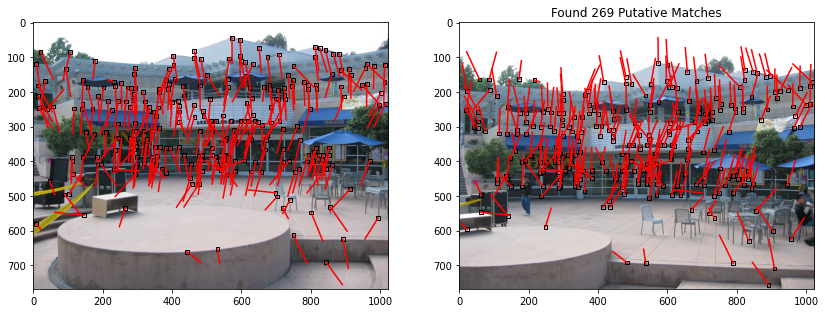

unique points in image 1: 269
unique points in image 2: 269


In [5]:
# parameters to tune
w = 11
t = 0.77
d = 0.8
p = 90

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = run_feature_matching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]

# # display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('Found %d Putative Matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 11
* t = 0.77
* d = 0.8
* p = 90
* num_matches = 269

## 3) Outlier Rejection

took 74.449723 secs
62 iterations
inlier count:  201
inliers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 91, 92, 93, 94, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 113, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 133, 134, 135, 136, 137, 138, 140, 142, 143, 144, 145, 146, 148, 149, 150, 151, 153, 154, 156, 157, 158, 159, 160, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 178, 180, 181, 182, 183, 184, 186, 187, 188, 189, 191, 192, 193, 195, 196, 197, 198, 199, 200, 202, 203, 205, 206, 207, 208, 209, 211, 212, 213, 214, 216, 217, 218, 220, 221, 224, 228, 229, 230, 231, 232, 233, 234, 235, 237, 239, 240, 241, 243, 244, 248, 250, 251, 252, 254, 256, 257, 258, 259, 263, 267, 268]
MSAC Cost = 361.101999

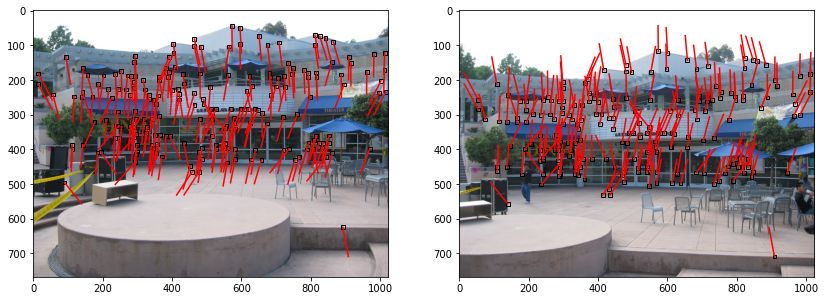

In [6]:
from scipy.stats import chi2
from scipy.linalg import null_space
from sympy import symbols, Eq, det, Matrix, Abs
from sympy.solvers import solve

def display_results(F, title):
    print(title+' =')
    print(F/np.linalg.norm(F)*np.sign(F[-1,-1]))

def homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates    
    return np.vstack((x,np.ones((1,x.shape[1]))))

def dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates   
    return x[:-1]/x[-1]
    
def compute_MSAC_cost(_F, _x1, _x2, _tol):
    # Inputs:
    # _x1 - 2D points in image 1
    # _x2 - 2D points in image 2
    # _F  - Fundamental matrix 
    # tol - tolerance for establishing datum/model compatibility
    #
    # Output:
    # cost - Squared sampson error
    
    error   = np.zeros(_x1.shape[1])
#     _x1     = homogenize(_x1)
    
    cost    = 0
    
    for i in range(_x1.shape[1]):
        x1         = _x1[:,i]
        x2         = _x2[:,i]
        
        epsilon    = x1[0]*x2[0]*_F[0,0] + x1[0]*x2[1]*_F[1,0] + x1[0]*_F[2,0] + x1[1]*x2[0]*_F[0,1] + x1[1]*x2[1]*_F[1,1] + x1[1]*_F[2,1] + x2[0]*_F[0,2] + x2[1]*_F[1,2] + _F[2,2]
        J          = np.zeros((1, 4))
        
        J[0,0]     = x2[0]*_F[0,0] + x2[1]*_F[1,0] + _F[2,0]
        J[0,1]     = x2[0]*_F[0,1] + x2[1]*_F[1,1] + _F[2,1]
        J[0,2]     = x1[0]*_F[0,0] + x1[1]*_F[0,1] + _F[0,2]
        J[0,3]     = x1[0]*_F[1,0] + x1[1]*_F[1,1] + _F[1,2]
        
        error[i]   = epsilon**2 / (J @ J.T)
        
        if error[i] <= tol:
            cost = cost + error[i]
            
        else:
            cost = cost + tol
 
    return error, cost

def minimal_solver(_pts1, _pts2, tol):
    # Inputs:
    #   _pts1     - Randomly selected 7 homogenous image1 points
    #   _pts2     - Randomly selected 7 homogenous image2 points
    #   tol       - tolerance for establishing datum/model compatibility
    
    # Output:
    #   _model    - Fundamental matrix
    
    A        = np.zeros((_pts1.shape[1], 9))
    _pts1    = homogenize(_pts1)
    _pts2    = homogenize(_pts2)
    
    for i in range(_pts1.shape[1]):
        A[i,:]  =  np.kron(_pts2[:,i].T, _pts1[:,i].T)
    
    f        = null_space(A)
    f1       = f[:, 0].reshape(3,3)
    f2       = f[:, 1].reshape(3,3)
    
    alpha    = symbols('alpha')
    _f1      = Matrix(f1)
    _f2      = Matrix(f2)
    eq1      = Eq(det(alpha*_f1 + _f2), 0, rational = False)
    sol      = solve(eq1)
    
    _cost    = np.inf
    _model   = np.zeros((3,3))
    
    for i in range(len(sol)):
        if sol[i].is_real or Abs(sol[i].as_real_imag()[1]) <= 1e-18:
            a            = sol[i].as_real_imag()[0]
            _F           = a*f1 + f2
            _, temp_cost = compute_MSAC_cost(_F, _pts1, _pts2, tol)
            
            if temp_cost < _cost:
                _cost  = temp_cost
                _model = _F
                
    return _model

def calculate_num_inliers(error, tol):
    # Inputs:
    #    error  - Squared sampson error
    #    tol    - reprojection error tolerance 
    #
    # Output:
    #    count  - Inlier count
    
    count = 0
    
    for i in range(len(error)):
        if error[i] <= tol:
            count = count + 1
    
    return count


def determine_inliers(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - fundamental matrix F
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    # Initialization of all variables
    trials                   = 0
    max_trials               = np.inf
    consensus_min_cost       = np.inf
    tau_cost                 = 0
    sample_size              = 7
    consensus_min_cost_model = np.zeros((3,3))
    
    # Set a random seed
    np.random.seed(50)
    
    # Loop
        
    while trials < max_trials and consensus_min_cost > tau_cost:
    
        # Randomly sample 7 data points from each image
        indices          = np.random.choice(pts1.shape[1], sample_size, replace = False)
        
        x1_i             = pts1[:, indices]
        x2_i             = pts2[:, indices]
               
        # Calculate the model with minimum consensus cost
        F                = minimal_solver(x1_i, x2_i, tol)
        
        # Calculate error for each data point using model and total cost
        error, cost      = compute_MSAC_cost(F, pts1, pts2, tol)
        
        # Calculate number of inliers using model 
        if cost < consensus_min_cost:
            consensus_min_cost       = cost
            consensus_min_cost_model = F
            num_inliers              = calculate_num_inliers(error, tol)
            w                        = num_inliers / pts1.shape[1]
            max_trials               = (np.log(1 - p)) / (np.log(1 - w**sample_size))

        trials = trials + 1
    
    # Calculate error using the consensus_min_cost_model and set of inliers
    error, _ = compute_MSAC_cost(consensus_min_cost_model, pts1, pts2, tol)
    inliers  = []
    
    for i in range( pts1.shape[1]):
        if error[i] <= tol:
            inliers.append(i)

    return consensus_min_cost, consensus_min_cost_model, inliers, trials


# MSAC parameters 
thresh      = 0
codimension = 1
p           = 0.99
alpha       = 0.95
tol         = chi2.ppf(alpha, df = codimension)

tic=time.time()

cost_MSAC, F_MSAC, inliers, trials = determine_inliers(match1, match2, thresh, tol, p)

# choose just the inliers
xin1 = match1[:,inliers]
xin2 = match2[:,inliers]

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost = %.9f'%cost_MSAC)
display_results(F_MSAC.astype(float), 'F_MSAC')

# display the figures
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)

for i in range(xin1.shape[1]):
    x1,y1 = xin1[:,i]
    x2,y2 = xin2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

#### Final values for parameters
* random seed = 50
* $p$ = 0.99
* $\alpha$ = 0.95
* tolerance = 3.841458820694124
* threshold = 0
* num_inliers = 201
* num_attempts = 62
* consensus_min_cost = 361.101999761

## 4) Linear Estimation of the Fundamental Matrix

In [7]:
def homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates    
    return np.vstack((x,np.ones((1,x.shape[1]))))

def dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates   
    return x[:-1]/x[-1]

def data_normalize(pts):
    # Input:
    # pts - 2D scene points
    # Outputs:
    # pts - data normalized points
    # T - corresponding transformation matrix
    
    # Calculate mean and variance for the scene points
    mu_x = np.mean(pts[0, :])
    mu_y = np.mean(pts[1, :])

    sigma_x = np.std(pts[0, :])
    sigma_y = np.std(pts[1, :])
    
    # Calculate s
    s = np.sqrt(2 / (sigma_x**2 + sigma_y**2))
    
    # Formulate Transformation matrix
    T = np.identity(3)
    T[0,0] = T[1,1] = s
    T[0,2] = -s * mu_x
    T[1,2] = -s * mu_y
    
    # Homogenize points
    pts = homogenize(pts)
    
    # Data normalize the points
    pts = T @ pts
    
    return pts, T

def estimate_fundamental_matrix_linear(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 2
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    F - the DLT estimate of the fundamental matrix  
    
    # data normalization
    if normalize:
        print('normalize')
        x1_DN, T1 = data_normalize(x1)
        x2_DN, T2 = data_normalize(x2)
    
    else:
        x1_DN = homogenize(x1)
        x2_DN = homogenize(x2)
    
    A        = np.zeros((x1.shape[1], 9))
    
    for i in range(x1.shape[1]):
        A[i,:]  =  np.kron(x2_DN[:,i].T, x1_DN[:,i].T)
    
    # Solution vector F and corresponding matrix form
    _, _, V = np.linalg.svd(A)
    
    F = V[-1, :].reshape(3,3)
    
    # Enforce F to rank 2
    U, sigma, VT = np.linalg.svd(F)
    sigma[2]     = 0
    F            = U @ np.diag(sigma) @ VT
    
    # data denormalization
    if normalize:
        print('denormalize') 
        F = T2.T @ F @ T1
       
    return F


# compute the linear estimate with data normalization
print ('DLT with Data Normalization')
time_start=time.time()
F_DLT = estimate_fundamental_matrix_linear(xin1, xin2, normalize=True)
time_total=time.time()-time_start

# display the resulting F_DLT, scaled with its frobenius norm
display_results(F_DLT, 'F_DLT')

DLT with Data Normalization
normalize
denormalize
F_DLT =
[[ 6.21810662e-09  2.16289742e-06 -7.41787849e-04]
 [-1.10284963e-06  6.15148175e-07 -1.06114512e-02]
 [ 4.79631372e-04  9.50209632e-03  9.99898158e-01]]


## 6) Nonlinear Estimation of the Fundamental Matrix

In [8]:
def sinc(x):
    
    # Calculates and returns sinc of a scalar
    
    if x == 0:
        y = 1
    
    else:
        y = (np.sin(x)) / x
        
    return y

def partial_sinc_partial_x(x):
    
    # Calculates and returns d_sinc_d_x of a scalar
    
    if x == 0:
        y = 0
    
    else:
        y = (np.cos(x) / x) - (np.sin(x) / x**2)
        
    return y


def parameterize_homog(v_bar):
    # Given a homogeneous vector v_bar (n x 1) return its minimal parameterization ((n - 1) x 1)
    
    # Make v_bar a unit vector
    v_bar = v_bar / np.linalg.norm(v_bar)
    
    v = v_bar[1:]
    v = ( 2 / ( sinc(np.arccos(v_bar[0])) ) ) * v 
    
    if np.linalg.norm(v) > np.pi:
        
        v_norm = np.linalg.norm(v)
        alpha  = 1 - ( (2 * np.pi / v_norm) * np.ceil( (v_norm - np.pi) / (2 * np.pi) ) )
        v      = alpha * v
    
    return v

def parameterize_matrix(P):
    # wrapper function to interface with LM
    # takes all optimization variables and parameterizes all of them

    return parameterize_homog(P.reshape(-1,1))

def deparameterize_matrix(m,rows,columns):
    # Deparameterize all optimization variables
    # Input:
    #   m - matrix to be deparameterized
    #   rows - number of rows of the deparameterized matrix 
    #   columns - number of rows of the deparameterized matrix 
    #
    # Output:
    #    deparameterized matrix

    return deparameterize_homog(m).reshape(rows,columns)


def deparameterize_homog(v):
    # Given a parameterized homogeneous vector (n x 1) return its deparameterization ((n + 1) x 1)
    
    v_bar     = np.zeros((v.shape[0]+1,1))
    v_norm    = np.linalg.norm(v)
    v_bar[0]  = np.cos(v_norm / 2)
    v_bar[1:] = 0.5 * sinc(v_norm / 2) * v
    v_bar     = v_bar / np.linalg.norm(v_bar)
    
    return v_bar


def partial_vbar_partial_v(v):
    # Input:
    # v - homogeneous parameterized vector (n x 1)
    # Output:
    # d_vbar_d_v - derivative of vbar w.r.t v ((n + 1) x n)
    
    d_vbar_d_v = np.zeros((v.shape[0]+1, v.shape[0]))
    
    v_norm     = np.linalg.norm(v)
    
    if v_norm == 0:
        d_vbar_d_v[1:, :] = 0.5 * np.identity(v.shape[0])
    
    else:
        d_vbar_d_v[0, :]  = -0.5 * 0.5 * sinc(v_norm / 2) * v.T
        term1             = 0.5 * sinc(v_norm / 2) * np.identity(v.shape[0]) 
        term2             = (1 / (4*v_norm)) * partial_sinc_partial_x(v_norm/2) * (v @ v.T)
        d_vbar_d_v[1:, :] = term1 + term2
    
    return d_vbar_d_v


def partial_x_hat_partial_p_hat(P, X):
    # compute the dx_hat_dp_hat component for the Jacobian
    #
    # Input:
    #    P - 3x4 projection matrix
    #    X - Homogenous 3D scene point (4x1)
    # Output:
    #    dx_hat_dp_hat - 2x11 matrix
    
    dx_hat_dp_hat = np.zeros((2, 11))
    
    x                     = dehomogenize(P @ X)
    w                     = P[2] @ X
    
    d_xhat_d_pbar         = np.zeros((2,12))
    
    d_xhat_d_pbar[0,0:4]  = X.T
    d_xhat_d_pbar[0,8:12] = -x[0] * X.T
    d_xhat_d_pbar[1,4:8]  = X.T
    d_xhat_d_pbar[1,8:12] = -x[1] * X.T
    
    d_xhat_d_pbar         = d_xhat_d_pbar / w
    
    d_pbar_d_phat         = partial_vbar_partial_v(parameterize_matrix(P))
    
    dx_hat_dp_hat         = d_xhat_d_pbar @ d_pbar_d_phat
    
    return dx_hat_dp_hat


def partial_x_hat_partial_X_hat(P, X):
    # compute the dx_hat_dX_hat component for the Jacobian
    #
    # Input:
    #    P - 3x4 projection matrix
    #    X - Homogenous 3D scene point (4x1)
    # Output:
    #    dx_hat_dX_hat - 2x3 matrix
    
    dx_hat_dX_hat = np.zeros((2, 3))
    
    x                    = dehomogenize(P @ X)
    w                    = P[2] @ X
    
    d_xhat_d_pbar        = np.zeros((2,4))
    
    d_xhat_d_pbar[0,:]   = P[0] - ( x[0] * P[2] )
    d_xhat_d_pbar[1,:]   = P[1] - ( x[1] * P[2] )
    
    d_xhat_d_pbar        = d_xhat_d_pbar / w
    
    d_pbar_d_phat        = partial_vbar_partial_v(parameterize_homog(X))

    dx_hat_dX_hat        = d_xhat_d_pbar @ d_pbar_d_phat
    
    return dx_hat_dX_hat

def data_normalize_with_cov(pts, covarx):
    # data normalization of n dimensional pts
    #
    # Input:
    # pts - is in inhomogeneous coordinates
    # covarx - covariance matrix associated with x. Has size 2n x 2n, where n is number of points.
    # Outputs:
    # pts - data normalized points
    # T - corresponding transformation matrix
    # covarx - normalized covariance matrix
    
    mu_x    = np.mean(pts[0, :])
    mu_y    = np.mean(pts[1, :])

    sigma_x = np.std(pts[0, :])
    sigma_y = np.std(pts[1, :])
    
    s       = np.sqrt(2 / (sigma_x**2 + sigma_y**2))
    
    # Formulate Transformation matrix
    T       = np.identity(3)
    T[0,0]  = T[1,1] = s
    T[0,2]  = -s * mu_x
    T[1,2]  = -s * mu_y
    
    pts     = homogenize(pts)
    
    # Data normalized points
    pts     = T @ pts
    
    # Compute Jacobian
    J       = s * np.identity(2)
    
    # Compute normalized covariance matrix
    for i in range(pts.shape[1]):
        covarx[2*i:2*(i+1), 2*i:2*(i+1)] = J @ covarx[2*i:2*(i+1), 2*i:2*(i+1)] @ J.T

    return pts, T, covarx

In [9]:
def retrieve_projection_matrices(F):
    # Input:
    #    F - DLT estimate of the fundamental matrix (3 x 3)
    # Output:
    #    P - First camera projection matrix
    #    P_prime - Second camera projection matrix
    
    P       = np.zeros((3, 4))
    P_prime = np.zeros((3, 4))
    W       = np.zeros((3,3))
    Z       = np.zeros((3,3))
    D_prime = np.zeros((3,3))
    v       = np.zeros((3,1))
    
    # Initialize P for first camera as Identity matrix with translation vector as zeros
    P[0,0] = P[1,1] = P[2,2] = 1
    
    U, D, VT = np.linalg.svd(F)
    
    # Formulate W matrix
    W[0,1]   = 1
    W[1,0]   = -1
    
    # Formulate Z matrix
    Z[0,1]   = -1
    Z[1,0]   = 1
    Z[2,2]   = 1
    
    # Formulate D'
    D_prime[0,0] = D[0]
    D_prime[1,1] = D[1]
    D_prime[2,2] = (D[0] + D[1]) / 2
    
    M        = U @ Z @ D_prime @ VT
    v_skew   = U @ W @ U.T
    
    v[0]     = v_skew[2,1]
    v[1]     = v_skew[0,2]
    v[2]     = v_skew[1,0]
    
    # Second camera Projection matrix 
    P_prime  = np.hstack((M, v))
    
    return P, P_prime


def apply_optimal_correction(x1, x2, F):
    # Input:
    #    x1 - Homogeneous point in image 1 (3 x 1)
    #    x2 - Homogeneous point in image 2 (3 x 1)
    #    F - DLT estimate of the fundamental matrix (3 x 3)
    # Output:
    #    x1_corrected - Homogeneous corrected point in image 1 (3 x 1)
    #    x2_corrected - Homogeneous corrected point in image 2 (3 x 1)
    
    # Initialization of variables
    T       = np.zeros((3,3))
    T_prime = np.zeros((3,3))
    R       = np.identity(3)
    R_prime = np.identity(3)
    
    # Formulate T and T'
    # T and T' are the transformations that translate the points to origin
    
    T[0,0] = T[1,1] = T[2,2] = x1[2]
    T[0,2] = -x1[0]
    T[1,2] = -x1[1]
    
    T_prime[0,0] = T_prime[1,1] = T_prime[2,2] = x2[2]
    T_prime[0,2] = -x2[0]
    T_prime[1,2] = -x2[1]
    
    Fs      = np.linalg.inv(T_prime).T @ F @ np.linalg.inv(T)
    
    e       = null_space(Fs)
    e_prime = null_space(Fs.T)
    
    e       = e / np.sqrt(e[0,0]**2 + e[1,0]**2)
    e_prime = e_prime / np.sqrt(e_prime[0,0]**2 + e_prime[1,0]**2)
    
    # Formulate R and R'
    # R and R' are the transformations that rotate scaled epipoles to x-axis
    
    R[0,0] = R[1,1] = e[0,0]
    R[0,1] = e[1,0]
    R[1,0] = -e[1,0]
    
    R_prime[0,0] = R_prime[1,1] = e_prime[0,0]
    R_prime[0,1] = e_prime[1,0]
    R_prime[1,0] = -e_prime[1,0]
    
    Fs = R_prime @ Fs @ R.T
    
    # Solving for 6 roots of g(t)
    
    a       = Fs[1,1]
    b       = Fs[1,2]
    c       = Fs[2,1]
    d       = Fs[2,2]
    f       = e[2,0]
    f_prime = e_prime[2,0]
    
    t       = symbols('t')
    eq1     = Eq( (t*(( ((a*t + b)**2) + (f_prime**2)*((c*t + d)**2) )**2))  - ( (a*d - b*c)*((1 + (f**2)*(t**2))**2)*(a*t + b)*(c*t + d) ) , 0)

    sol     = solve(eq1, t, simplify = False, rational=False)
    
    # Determination of t_min
    
    s_min   = np.inf
    t_min   = 0
    
    for i in range(len(sol)):
        
        _t       = sol[i].as_real_imag()[0]
        temp_val = (_t**2 / (1 + (f**2) * (_t**2))) + ( (((c*_t) + d)**2) / ( (((a*_t) + b)**2) + ((f_prime**2) * (((c*_t) + d)**2)) ) )
        
        if temp_val < s_min:
            
            s_min = temp_val
            t_min = _t
            
    temp_val = (1 / (f**2)) + ( c**2 / ((a**2) + ((f_prime**2)*(c**2))) )
    
    if temp_val < s_min:
        s_min = temp_val
        t_min = np.inf
        
    if t_min == np.inf:
        ls1_t_min = np.array([f, 0, -1])
        ls2_t_min = np.array([-f_prime*c, a, c])
    
    else:
        ls1_t_min = np.array([t_min*f, 1, -t_min])
        ls2_t_min = np.array([-f_prime*(c*t_min + d), (a*t_min + b), (c*t_min + d)])
    
    # Compute optimally corrected points
    
    _a = ls1_t_min[0]
    _b = ls1_t_min[1]
    _c = ls1_t_min[2]
    
    xs1_cap      = np.array([-_a*_c, -_b*_c, _a**2 + _b**2])
    x1_corrected = (np.linalg.inv(T) @ R.T @ xs1_cap).reshape(3,1)
    
    _a = ls2_t_min[0]
    _b = ls2_t_min[1]
    _c = ls2_t_min[2]
    
    xs2_cap      = np.array([-_a*_c, -_b*_c, _a**2 + _b**2])
    x2_corrected = (np.linalg.inv(T_prime) @ R_prime.T @ xs2_cap).reshape(3,1)    

    return x1_corrected, x2_corrected


def triangulate_scene_point(x1, x2, F):
    # Input:
    #    x1 - Homogeneous point in image 1 (3 x 1)
    #    x2 - Homogeneous point in image 2 (3 x 1)
    #    F - DLT estimate of the fundamental matrix (3 x 3)
    # Output:
    #    X_scene = Triangulated homogeneous 3D scene point (4 x 1)
    
    X_scene  = np.zeros((4,1))

    """your code here"""
    
    # Apply optimal correction on the input points
    x1, x2   = apply_optimal_correction(x1, x2, F)
    
    # Calculate the line l_prime
    l2       = F @ x1
    
    # Calculate the line orthogonal to l_prime
    l2_ortho = np.array([-l2[1,0]*x2[2,0], l2[0,0]*x2[2,0], (l2[1,0]*x2[0,0]) - (l2[0,0]*x2[1,0])])
    
    # Retrieve Projection matrices from F
    _P, _P_prime = retrieve_projection_matrices(F)
    
    # Backproject l2_ortho to 3D plane
    pi       = _P_prime.T @ l2_ortho
    
    # Backproject x1 to 3D line
    X        = _P.T @ x1
    
    # Calculate the scene point
    X_scene[:3,0] = (pi[3] * x1).reshape(3,)
    X_scene[3,0]  = -(pi[0:3] @ x1)
    
    return X_scene

In [10]:
# Unit tests for Jacobian (Do not change)

def check_values_jacobian():
    eps = 1e-5  # Floating point error threshold
    
    # Givens
    # The parameterized second camera projection matrix (11 x 1)
    p_hat_prime = np.load('unit_test/p_hat_prime.npy')
    
    # The parameterized scene point (3 x 1)
    X_hat = np.load('unit_test/X_hat.npy')
    
    # The first camera projection matrix (3 x 4)
    P = np.load('unit_test/P.npy')
    
    # Targets
    dp_bar_prime_dp_hat_prime_target = np.load('unit_test/dp_bar_prime_dp_hat_prime.npy') 
    dX_bar_dX_hat_target = np.load('unit_test/dX_bar_dX_hat.npy')
    dx_hat_prime_dp_hat_prime_target = np.load('unit_test/dx_hat_prime_dp_hat_prime.npy')
    dx_hat_prime_dX_hat_target = np.load('unit_test/dx_hat_prime_dX_hat.npy')
    dx_hat_dX_hat_target = np.load('unit_test/dx_hat_dX_hat.npy')
    
    # Compute
    dp_bar_prime_dp_hat_prime = partial_vbar_partial_v(p_hat_prime)
    dX_bar_dX_hat = partial_vbar_partial_v(X_hat)
    
    P_prime = deparameterize_homog(p_hat_prime).reshape((3, 4))
    X = deparameterize_homog(X_hat)  # (4 x 1) vector
    
    dx_hat_prime_dp_hat_prime = partial_x_hat_partial_p_hat(P_prime, X)
    dx_hat_prime_dX_hat = partial_x_hat_partial_X_hat(P_prime, X)
    dx_hat_dX_hat = partial_x_hat_partial_X_hat(P, X)
    
    # Check
    dp_bar_prime_dp_hat_prime_valid = np.all(np.abs(dp_bar_prime_dp_hat_prime_target - dp_bar_prime_dp_hat_prime) < eps)
    dX_bar_dX_hat_valid = np.all(np.abs(dX_bar_dX_hat_target - dX_bar_dX_hat) < eps)
    dx_hat_prime_dp_hat_prime_valid = np.all(np.abs(dx_hat_prime_dp_hat_prime_target - dx_hat_prime_dp_hat_prime) < eps)
    dx_hat_prime_dX_hat_valid = np.all(np.abs(dx_hat_prime_dX_hat_target - dx_hat_prime_dX_hat) < eps)
    dx_hat_dX_hat_valid = np.all(np.abs(dx_hat_dX_hat_target - dx_hat_dX_hat) < eps)
    
    print(f'Computed partial_pbar\'_partial_phat\' is equal to the given value +/- {eps}: {dp_bar_prime_dp_hat_prime_valid}')
    print(f'Computed partial_Xbar_partial_Xhat is equal to the given value +/- {eps}: {dX_bar_dX_hat_valid}')
    print(f'Computed partial_xhat\'_partial_phat\' is equal to the given value +/- {eps}: {dx_hat_prime_dp_hat_prime_valid}')
    print(f'Computed partial_xhat\'_partial_Xhat is equal to the given value +/- {eps}: {dx_hat_prime_dX_hat_valid}')
    print(f'Computed partial_xhat_partial_Xhat is equal to the given value +/- {eps}: {dx_hat_dX_hat_valid}')
    
check_values_jacobian()

Computed partial_pbar'_partial_phat' is equal to the given value +/- 1e-05: True
Computed partial_Xbar_partial_Xhat is equal to the given value +/- 1e-05: True
Computed partial_xhat'_partial_phat' is equal to the given value +/- 1e-05: True
Computed partial_xhat'_partial_Xhat is equal to the given value +/- 1e-05: True
Computed partial_xhat_partial_Xhat is equal to the given value +/- 1e-05: True


In [11]:
# Unit tests for optimal triangulation (Do not change)

def check_values_triangulation():
    eps = 1e-5  # Floating point error threshold
    
    # Givens
    # The fundamental matrix (3 x 3)
    F = np.load('unit_test/F.npy')
   
    # Camera projection matrices (3 x 4) each
    P_target = np.zeros((3, 4))
    P_target[:3, :3] = np.eye(3)
    
    # Homogeneous image points (3 x 1) each
    x1 = np.load('unit_test/x1.npy') 
    x2 = np.load('unit_test/x2.npy')
    
    # Targets
    x1_corr_target = np.load('unit_test/x1_corr.npy')
    x2_corr_target = np.load('unit_test/x2_corr.npy')
    
    # Compute
    P, P_prime = retrieve_projection_matrices(F)
    x1_corr, x2_corr = apply_optimal_correction(x1, x2, F)
    X_scene = triangulate_scene_point(x1, x2, F)
    
    # Verify optimal corrected points
    P_valid = np.all(np.abs(P - P_target) < eps)
    x1_corr_valid = np.all(np.abs(dehomogenize(x1_corr_target) - dehomogenize(x1_corr)) < eps)
    x2_corr_valid = np.all(np.abs(dehomogenize(x2_corr_target) - dehomogenize(x2_corr)) < eps)
    
    # Verify second camera projection matrix
    _, D_P, _ = np.linalg.svd(P_prime[:3, :3])
    U, D_F, _ = np.linalg.svd(F)
    
    s, t = D_F[:-1]
    D_P_target = np.array([s, (s + t) / 2, t])
    D_P_valid = np.all(np.abs(D_P - D_P_target) < eps)
    
    t = P_prime[:, -1]
    t_target = U[:, -1]
    t_valid = np.all(np.abs(t / np.sign(t[0]) - t_target / np.sign(t_target[0])) < eps)
    
    P_prime_valid = D_P_valid and t_valid
    
    # Verify triangulated 3D scene point
    x1_proj = dehomogenize(P @ X_scene)
    x2_proj = dehomogenize(P_prime @ X_scene)
    
    x1_proj_valid = np.all(np.abs(x1_proj - dehomogenize(x1_corr)) < eps)
    x2_proj_valid = np.all(np.abs(x2_proj - dehomogenize(x2_corr)) < eps)
    X_scene_valid = x1_proj_valid and x2_proj_valid
    
    print(f'Computed first camera projection matrix is equal to the given value +/- {eps}: {P_valid}')
    print(f'Computed second camera projection matrix is equal to the given value +/- {eps}: {P_prime_valid}')
    print(f'Computed optimal corrected point in image 1 is equal to the given value +/- {eps}: {x1_corr_valid}')
    print(f'Computed optimal corrected point in image 2 is equal to the given value +/- {eps}: {x2_corr_valid}')
    print(f'Computed triangulated 3D scene point is equal to the given value +/- {eps}: {X_scene_valid}')
    
check_values_triangulation()

Computed first camera projection matrix is equal to the given value +/- 1e-05: True
Computed second camera projection matrix is equal to the given value +/- 1e-05: True
Computed optimal corrected point in image 1 is equal to the given value +/- 1e-05: True
Computed optimal corrected point in image 2 is equal to the given value +/- 1e-05: True
Computed triangulated 3D scene point is equal to the given value +/- 1e-05: True


In [15]:
from scipy.linalg import block_diag

def data_normalize_3D_pts(_pts):
    
    mu_x = np.mean(_pts[0, :])
    mu_y = np.mean(_pts[1, :])
    mu_z = np.mean(_pts[2, :])

    sigma_x = np.std(_pts[0, :])
    sigma_y = np.std(_pts[1, :])
    sigma_z = np.std(_pts[2, :])

    s = np.sqrt(2 / (sigma_x**2 + sigma_y**2 + sigma_z**2))

    T = np.identity(4)
    T[0,0] = T[1,1] = T[2,2] = s
    T[0,3] = -s * mu_x
    T[1,3] = -s * mu_y
    T[2,3] = -s * mu_z
        
    _pts = T @ _pts
    
    return _pts, T

def skew(w):
    # Returns the skew-symmetrix representation of a vector
    
    w_skew = np.zeros((3, 3))
    
    w_skew[0, 1] = -w[2]
    w_skew[0, 2] = w[1]
    w_skew[1, 0] = w[2]
    w_skew[1, 2] = -w[0]
    w_skew[2, 0] = -w[1]
    w_skew[2, 1] = w[0]    
    
    return w_skew

def estimate_fundamental_matrix_nonlinear(F, x1, x2, max_iters, lam):
    # Input:
    #    F - DLT estimate of the fundamental matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    F - Final fundamental matrix obtained after convergence
        
    n_points           = x1.shape[1]
    
    # Initialize scene points using two-view optimal traingulation
    scene_pts          = np.zeros((4, n_points)) # 4 x n 
    x1_homo            = homogenize(x1)
    x2_homo            = homogenize(x2)
    
    for i in range(n_points):
        scene_pts[:,i]    = triangulate_scene_point(x1_homo[:,i], x2_homo[:,i], F).reshape(4,)
    
    # Data normalize the scene points
    scene_pts_DN, U    = data_normalize_3D_pts(scene_pts)
    
    # Parameterize and deparameterize the scene points
    for i in range(n_points):
        scene_pts_DN[:,i] = deparameterize_homog((parameterize_homog(scene_pts_DN[:,i])).reshape(3,1)).reshape(4,)
     
    # Data normalize the points and associated covariance matrices
    x1_DN, T1, covarx1 = data_normalize_with_cov(x1, np.eye(2 * n_points)) # x1_DN = homogenous with last row = 1
    x2_DN, T2, covarx2 = data_normalize_with_cov(x2, np.eye(2 * n_points)) # x2_DN = homogenous with last row = 1
    
    # Dehomogenize image1 and image2 data normalized points
    x1_DN              = dehomogenize(x1_DN)
    x2_DN              = dehomogenize(x2_DN) 
     
    # Retrieve Projection matrices from F
    P, P_prime         = retrieve_projection_matrices(F)
    
    # Data normalize the camera projection matrices
    P_DN               = T1 @ P @ np.linalg.inv(U) 
    P_prime_DN         = T2 @ P_prime @ np.linalg.inv(U)
    
    P_prime_DN    = deparameterize_matrix((parameterize_matrix(P_prime_DN)), 3, 4)
    
    # Normal equations vector
    epsilon1      = x1_DN - dehomogenize(P_DN @ scene_pts_DN)
    epsilon2      = x2_DN - dehomogenize(P_prime_DN @ scene_pts_DN)
    
    # Compute initial cost
    cost  = 0
    for i in range(n_points):
        eps1     = epsilon1[:,i]
        eps2     = epsilon2[:,i]
        cost     = cost + (eps1.T @ np.linalg.inv(covarx1[2*i:2*(i+1), 2*i:2*(i+1)]) @ eps1) + (eps2.T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ eps2)

    print ('iter %03d Cost %.9f'%(0, cost))
    
    previous_cost = cost
    
    for j in range(max_iters): 
        
        # Variable Initializations
        U2            = np.zeros((11,11))
        A2            = np.zeros((2 * x2.shape[1], 11))
        B1            = np.zeros((2 * x1.shape[1], 3))
        B2            = np.zeros((2 * x2.shape[1], 3))
        V             = np.zeros((3 * x2.shape[1], 3))
        W2            = np.zeros((3 * x2.shape[1], 11))
        epsilon_a     = np.zeros((11, 1))
        

        # Normal equations matrix
        for i in range(n_points):
            A2_i               = partial_x_hat_partial_p_hat(P_prime_DN, scene_pts_DN[:,i])
            B1_i               = partial_x_hat_partial_X_hat(P_DN, scene_pts_DN[:,i])
            B2_i               = partial_x_hat_partial_X_hat(P_prime_DN, scene_pts_DN[:,i])
            V_i                = (B1_i.T @ np.linalg.inv(covarx1[2*i:2*(i+1), 2*i:2*(i+1)]) @ B1_i) + (B2_i.T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ B2_i)
            W2_i               = A2_i.T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ B2_i
            U2                 = U2 + (A2_i.T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ A2_i)
            A2[2*i:2*(i+1), :] = A2_i
            B1[2*i:2*(i+1), :] = B1_i
            B2[2*i:2*(i+1), :] = B2_i
            V[3*i:3*(i+1), :]  = V_i
            W2[3*i:3*(i+1), :] = W2_i.T
         
        for i in range(n_points):
            epsilon_a   = epsilon_a + (A2[2*i:2*(i+1), :].T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon2[:,i].reshape(2,1)) # 11x1 
        
        # Reinitializations
        temp_sum1              = np.zeros((11, 11))
        temp_sum2              = np.zeros((11, 1))
        new_scene_points       = np.zeros((4, n_points))
        fac                    = (180000)**(j+1)
        for i in range(n_points):
            V_star_i    = V[3*i:3*(i+1), :] + (lam * np.identity(3)) # 3x3
            if np.linalg.det(V_star_i) == 0.0:
                V_star_i = np.copy(prev)
            epsilon_b_i = (B1[2*i:2*(i+1), :].T @ np.linalg.inv(covarx1[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon1[:,i].reshape(2,1)) + (B2[2*i:2*(i+1), :].T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon2[:,i].reshape(2,1)) # 3x1
            temp_sum1   = temp_sum1 + (W2[3*i:3*(i+1), :].T @ np.linalg.inv(V_star_i) @ W2[3*i:3*(i+1), :]) # 11x11
            temp_sum2   = temp_sum2 + (W2[3*i:3*(i+1), :].T @ np.linalg.inv(V_star_i) @ epsilon_b_i)        # 11x1
            prev        = np.copy(V_star_i)
        
        # Solve for delta
        S2            = (U2 + (lam * np.identity(11))) - temp_sum1 # 11x11
        e2            = epsilon_a - temp_sum2                      # 11x1
        
        delta_a_2     = (np.linalg.solve(S2, e2)) / fac
        
        # Candidate parameter vector
        P0_prime      = deparameterize_matrix((parameterize_matrix(P_prime_DN) + delta_a_2), 3, 4)
        
        for i in range(n_points):
            V_star_i              = V[3*i:3*(i+1), :] + (lam * np.identity(3))
            epsilon_b_i           = (B1[2*i:2*(i+1), :].T @ np.linalg.inv(covarx1[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon1[:,i].reshape(2,1)) + (B2[2*i:2*(i+1), :].T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon2[:,i].reshape(2,1))
            if np.linalg.det(V_star_i) == 0.0:
                V_star_i = np.copy(prev)
            delta_b_i             = (np.linalg.inv(V_star_i) @ (epsilon_b_i - (W2[3*i:3*(i+1), :] @ delta_a_2)))
            new_scene_points[:,i] = deparameterize_homog((parameterize_homog(scene_pts_DN[:,i]) + delta_b_i.reshape(3,)).reshape(3,1)).reshape(4,)
            prev                  = np.copy(V_star_i)
        
        P_prime_DN    = np.copy(P0_prime)
        lam           = lam/10
        
        # Compute cost
        
        # Normal equations vector
        epsilon1      = x1_DN - dehomogenize(P_DN @ scene_pts_DN)
        epsilon2      = x2_DN - dehomogenize(P_prime_DN @ scene_pts_DN)
               
        cost          = 0
        
        for i in range(n_points):
            eps1     = epsilon1[:,i]
            eps2     = epsilon2[:,i]
            cost     = cost + (eps1.T @ np.linalg.inv(covarx1[2*i:2*(i+1), 2*i:2*(i+1)]) @ eps1) + (eps2.T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ eps2)

        print ('iter %03d Cost %.9f'%(j+1, cost))
        
        if previous_cost != 0:
            if (1 - (cost/previous_cost)) < 1e-7:
                break
        
        if cost > previous_cost:
            print('Inner Loop!')
            lam = lam * 10
        
        previous_cost = cost
     
    # De-normalize P_prime
    P_prime = np.linalg.inv(T2) @ P_prime_DN @ U
    
    # Calculate F from P_prime
    F       = skew(P_prime[:,-1]) @ P_prime[0:3, 0:3]
    
    return F

# LM hyperparameters
lam = .001
max_iters = 10

# Run LM initialized by DLT estimate
print ('Sparse LM')
time_start=time.time()

F_LM = estimate_fundamental_matrix_nonlinear(F_DLT, xin1, xin2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

# display the resulting F_LM, scaled with its frobenius norm
display_results(F_LM, 'F_LM')

Sparse LM
iter 000 Cost 57.757367996
iter 001 Cost 57.757334867
iter 002 Cost 57.757334867
took 25.364146 secs
F_LM =
[[ 6.21812025e-09  2.16289746e-06 -7.41788012e-04]
 [-1.10284962e-06  6.15148119e-07 -1.06114513e-02]
 [ 4.79631500e-04  9.50209636e-03  9.99898158e-01]]


## 7) Point to Line Mapping

C:\Users\Sanchit Gupta\AppData\Local\Temp\ipykernel_12692\148113472.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(xx,yy,'-r', color=colors[i])


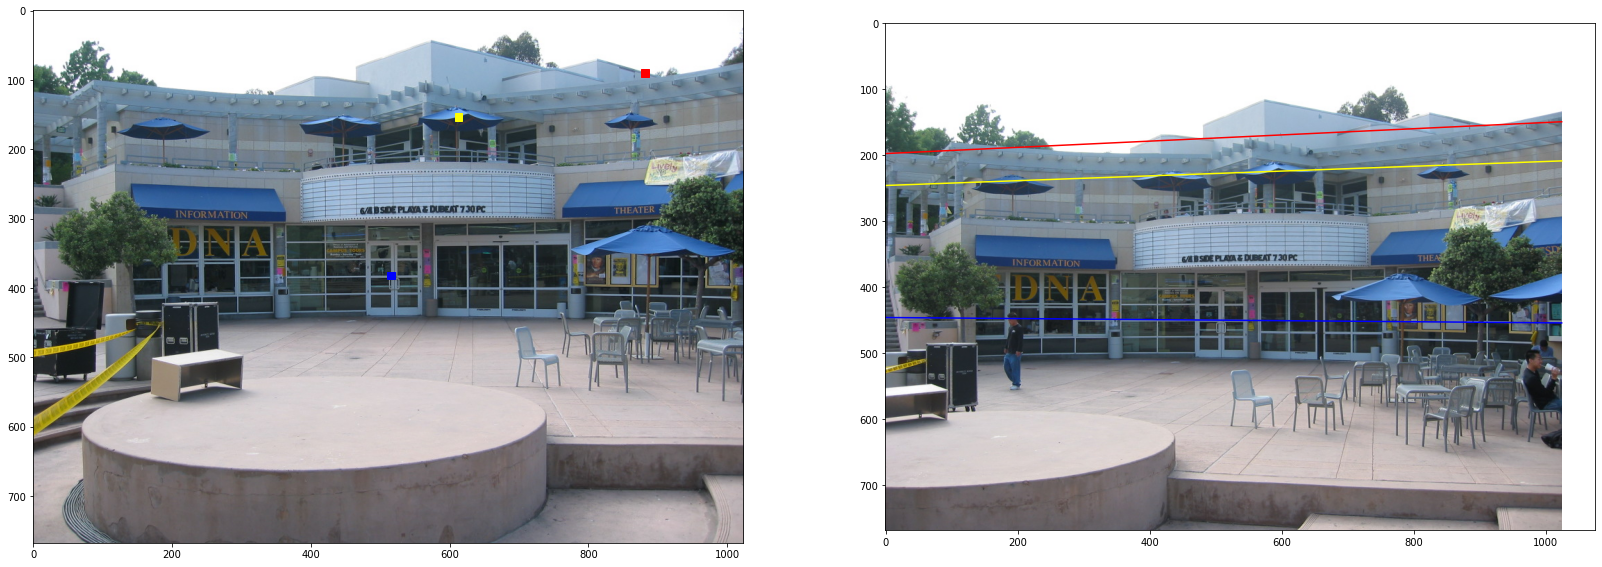

In [14]:
# Store your three points in image 1 in variable xchosen1
# Store the corresponding epipolar lines in variable epi_lines

# You can modify the code to display the figures, to highlight the corresponding point in image 2.
#    You will have to find the pixel co-ordinates of the 
#    corresponding point in image 2 manually, as we are explicitly choosing outliers(find the real matching point
#    and not the one your code outputs). The epipolar lines should
#    pass close by or through these points.
# 

# Outliers = 12, 17 and 50
xchosen1  = match1[:, (12,17,50)]
epi_lines = F_LM @ homogenize(xchosen1)

# display the figures
plt.figure(figsize=(28,16))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
im_height, im_width = I1.shape[:2]
x_ax = np.linspace(0, im_width, im_width*10)
colors = ['red', 'blue', 'yellow']
for i in range(xchosen1.shape[1]):
    a, b, c = epi_lines[:, i]
    xx, yy = [], []
    for xval in x_ax:
        yval = -(a/b)*xval - c/b
        if yval > 0 and yval < im_width:
            xx.append(xval)
            yy.append(yval)
    x1,y1 = xchosen1[:,i]
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=True, color=colors[i]))
    ax2.plot(xx,yy,'-r', color=colors[i])
plt.show()

Three different outlier points were chosen. They were plotted in Image 1 and their corresponding epipolar lines were plotted in Image 2. It can be observed that the mapping of points to the epipolar lines is quite accurate and this inference is from the qualitative observation of the points in image 1 to epipolar lines in image 2 under Fundamental matrix F_LM. This shows that the estimation of F_LM after non-linear estimation process is quite accurate.